In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pystan
import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
df = pd.read_csv('data/president_general_polls_2016.csv')

## data cleaning

In [3]:
polls = df[['pollster', 'grade', 'state', 'createddate', 'samplesize', 'adjpoll_trump', 'adjpoll_clinton']]
polls.createddate = pd.to_datetime(polls.createddate)

nb_voters = [3606103, 519501, 4738332, 2148441, 25278803, 3978892, 2572337, 693659, 516771, 14601373, 6958725, 
             1029072, 1161211, 8983758, 4860929, 2297129, 2065761, 3276707, 3391431, 1058306, 4202282, 4978165, 
             7431589, 3972330, 2177349, 4519978, 803833, 1353558, 1970426, 1041147, 6093144, 1459901, 13693128, 
             7317507, 582534, 8753269, 2792423, 3006638, 9737690, 786111, 3702997, 632098, 4900137, 17514961, 
             1993581, 496439, 6061032, 5123524, 1430308, 4295057, 431011]

nb_voters = [2074338,301694,2323579,1078548,13202158,2596173,1560640,413921,294254,8538264,3919355,437159,666290,
             5279752,2663368,1589951,1182771,1815843,2014548,724758,2734062,3184196,4780701,2950780,1285584,
             2757323,491966,804245,1016664,718700,3683638,786522,7128852,4542488,325564,5632423,1334872,1820507,
             5742040,446049,1981516,368270,2478870,7993851,1028786,301793,3888186,3172939,670438,3068434,250701]

nb_electors = [9, 3, 11, 6, 55, 9, 7, 3, 3, 29, 16, 4, 4, 20, 11, 6, 6, 8, 8, 4, 10, 11, 16, 10, 6, 10, 3, 5, 6, 
               4, 14, 5, 29, 15, 3, 18, 7, 7, 20, 4, 9, 3, 11, 38, 6, 3, 13, 12, 5, 10, 3]

states = sorted(list(set(df.state.values)))
to_remove = ['U.S.', 'Nebraska CD-1', 'Nebraska CD-2', 'Nebraska CD-3', 'Maine CD-1', 'Maine CD-2']
for s in to_remove: states.remove(s)
polls = polls[polls.state.isin(states)]

grades = ['A-', 'A', 'A+', 'B+', 'B']
polls = polls[polls.grade.isin(grades)]
polls = polls[polls.createddate > pd.to_datetime('2016/10/30')]
polls.dropna(inplace=True)

polls.samplesize = polls.samplesize.astype(np.int32)
polls['trump'] = (polls.samplesize*polls.adjpoll_trump/100).astype(np.int32)
polls['clinton'] = (polls.samplesize*polls.adjpoll_clinton/100).astype(np.int32)
polls['independent'] = (polls.samplesize - (polls.clinton + polls.trump))

done = set()
idxs = []
for idx in polls.createddate.sort_values(ascending=False).index:
    if polls.ix[idx].state not in done:
        idxs.append(idx)
        done.add(polls.ix[idx].state)
polls = polls.ix[idxs]

polls_states = [states.index(s) for s in polls.state.values]
votes = polls[['trump', 'clinton', 'independent']].values

# Model

In [4]:
code = '''
data {
    int nb_polls;
    int nb_states;
    int nb_candidates;
    int polls_states[nb_polls];
    int votes[nb_polls, nb_candidates];
    int nb_voters[nb_states];
}
parameters {
    simplex[nb_candidates] theta[nb_states]; //1 - trump, 2 - clinton, 3 - independent
    vector[nb_candidates] alpha;
}
model {
    for(c in 1:nb_candidates)
        alpha[c] ~ uniform(0, 100);
        
    for(s in 1:nb_states)
        theta[s] ~ dirichlet(alpha); 
        
    for(p in 1:nb_polls)
        votes[p] ~ multinomial(theta[polls_states[p]]);
}
generated quantities{
    int votes_pred[nb_states, nb_candidates];
    for(s in 1:nb_states)
        votes_pred[s] <- multinomial_rng(theta[s], nb_voters[s]);
}
'''

model = pystan.StanModel(model_code=code)

In [5]:
data = {
    'nb_polls': len(polls_states),
    'nb_states': len(states),
    'nb_candidates': votes.shape[-1],
    'polls_states': np.array(polls_states)+1,
    'votes': votes,
    'nb_voters': nb_voters,
}

fit = model.sampling(data=data, iter=1000, chains=4)

In [6]:
print(fit)

Inference for Stan model: anon_model_32e2a9df71897ab7e0f0920db4e988dc.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0,0]         0.54  3.0e-4   0.01   0.52   0.53   0.54   0.55   0.57   2000    1.0
theta[1,0]          0.4  7.1e-4   0.03   0.34   0.38    0.4   0.42   0.46   2000    1.0
theta[2,0]         0.49  2.9e-4   0.01   0.46   0.48   0.48   0.49   0.51   2000    1.0
theta[3,0]         0.51  7.3e-4   0.03   0.44   0.49   0.51   0.53   0.57   2000    1.0
theta[4,0]         0.32  3.6e-4   0.02   0.28    0.3   0.31   0.33   0.35   2000    1.0
theta[5,0]         0.39  2.7e-4   0.01   0.37   0.39   0.39    0.4   0.42   2000    1.0
theta[6,0]         0.38  3.6e-4   0.02   0.35   0.37   0.38    0.4   0.42   2000    1.0
theta[7,0]         0.35  6.1e-4   0.03    0.3   0.33   0.35   0.37    0.4   2000    1.0
theta[8,0]         0.

In [7]:
trace = fit.extract()

<IPython.core.display.Javascript object>


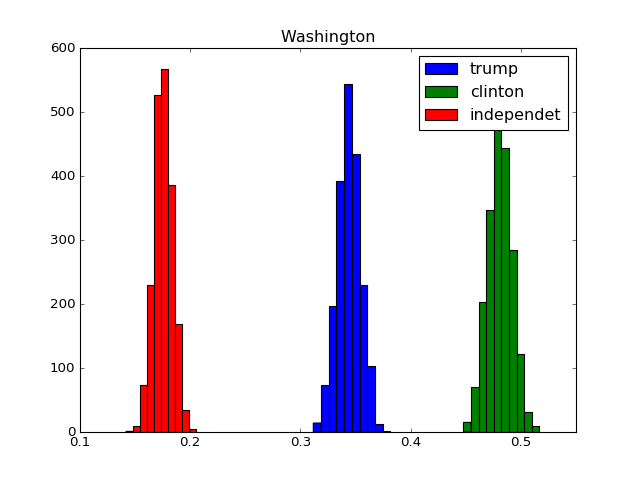

In [8]:
plt.figure()
s = 47
plt.hist(trace['theta'][:, s, 0], label='trump')
plt.hist(trace['theta'][:, s, 1], label='clinton')
plt.hist(trace['theta'][:, s, 2], label='independet')
plt.title(sorted(list(states))[s])
plt.legend()

In [9]:
votes_pred = trace['votes_pred']

In [10]:
votes_pred.shape

(2000, 51, 3)

In [11]:
winner = []
for election_sample in votes_pred:
    cnts = np.zeros(3)
    for s, tci in enumerate(election_sample):
        cnts[tci.argmax()] += nb_electors[s]
    if cnts.max() >= 270:
        winner.append(cnts.argmax())
    else:
        winner.append(-1)

In [12]:
set(winner)

{-1, 0, 1}

In [13]:
np.histogram(winner, bins=3)[0]/len(winner)

array([ 0.04 ,  0.051,  0.909])

<IPython.core.display.Javascript object>


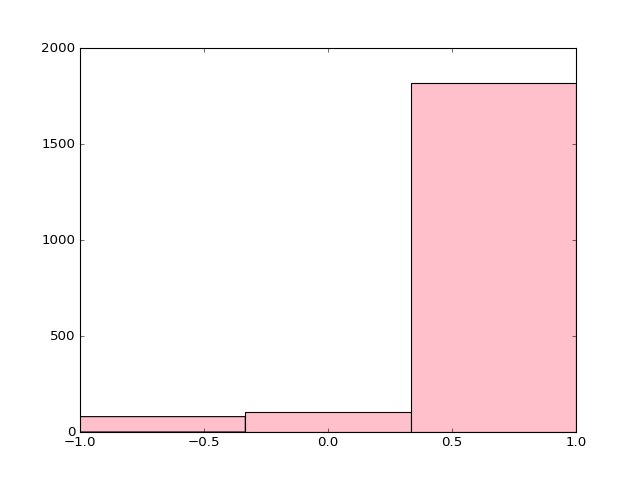

In [14]:
plt.figure()
plt.hist(winner, bins=3, color='pink');